## Individual Assignment 1, International Climate Policy

- Neil Stein, 12410247

- [Github URL](https://github.com/neil-stein/Assignment-2_ICP.git)

In [49]:
# Setup steps
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas
import warnings
import scipy
import time
import re
import scipy

warnings.filterwarnings("ignore")

# data loading steps
county_df = pd.read_csv("icp_indiv_2_county_avetemp.csv")
rep_df = pd.read_csv("icp_indiv_2_dg2011_rep_nomiss.csv")

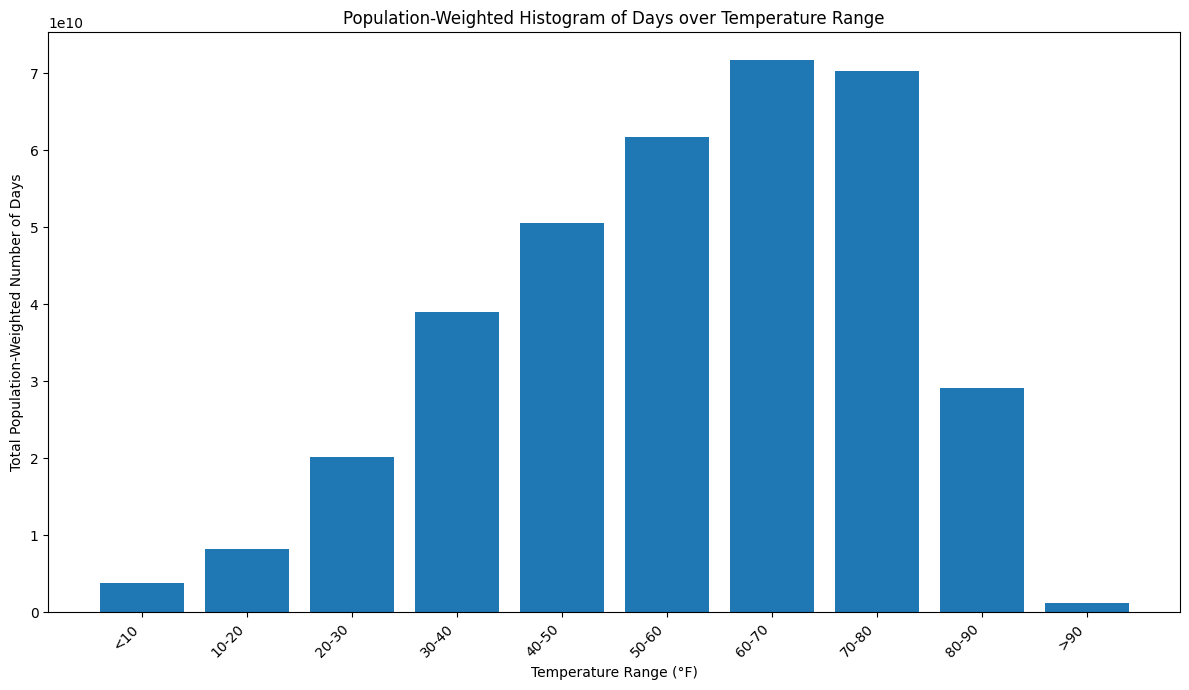

In [50]:
# Part 1(a) -- plotting temp and US population

# creating a merged dataset 
merged_df = pd.merge(rep_df, county_df, left_on= "countycode", right_on= "countycode", how= "left")

# recategorizing our temperature range columns into more precise values
temp_range_pattern = re.compile(r'tday_(lt\d+|gt\d+|\d+_\d+)')
temp_range_cols  = [col for col in merged_df.columns if temp_range_pattern.match(col)]

# duplicating the dataframe to avoid messy crossover between temperature weights
popweight_tempdf = merged_df.copy()

# applying the weights
for temp_col in temp_range_cols:
    popweight_tempdf[f'weighted_{temp_col}'] = popweight_tempdf[temp_col] * popweight_tempdf['population']

# Aggregate the population-weighted days across all rows (summing for each weighted temperature column)
total_weighted_days = popweight_tempdf[[col for col in popweight_tempdf.columns if col.startswith('weighted_tday_')]].sum()

# Prepare labels for the x-axis
bin_labels = [col.replace('weighted_tday_', '').replace('lt', '<').replace('gt', '>').replace('_', '-') for col in total_weighted_days.index]
bin_values = total_weighted_days.values

# Create the histogram
plt.figure(figsize=(12, 7))
plt.bar(bin_labels, bin_values)
plt.xlabel("Temperature Range (°F)")
plt.ylabel("Total Population-Weighted Number of Days")
plt.title("Population-Weighted Histogram of Days over Temperature Range")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [51]:
# Part 1(b) - number of days about 90°F as a population weighted average
# first, we need the total population in the context of this data
total_pop = popweight_tempdf['population'].sum()

# next, the population weighted days above 90°F
total_above90 = popweight_tempdf['weighted_tday_gt90'].sum()

# last, creating our population weighted average
popweight_avg_over90 = total_above90/total_pop
print(f'The population-weighted average number of days above 90°F per year across the US is: {popweight_avg_over90:.2f} days.')

The population-weighted average number of days above 90°F per year across the US is: 1.21 days.


In [52]:
# Part 1(c) - finding the max and the non-90°F locations

# first, our county with the most days above 90°F
county_above90 = popweight_tempdf.groupby('county_x')['tday_gt90'].max()
county_with_highest_above_90 = county_above90.idxmax()
max_days_above_90 = county_above90.max()

print(f'The county with the most days above 90°F is {county_with_highest_above_90} with {max_days_above_90:.0f} days')

# next, counting the number of counties without 90°F days
zero_days_above_90_df = popweight_tempdf[popweight_tempdf['tday_gt90'] == 0]
unique_counties_with_zero_days = zero_days_above_90_df['county_x'].unique()
num_unique_counties_with_zero_days = len(unique_counties_with_zero_days)
print(f'The number of counties with zero days above 90°F is: {num_unique_counties_with_zero_days}')

The county with the most days above 90°F is Yuma County, AZ with 100 days
The number of counties with zero days above 90°F is: 2894


# 2(a) - pre-question

As the prompt suggests, I searched for the national all age mortality rate during the latest time period of the data (2002) before exploring the data-based approach. I found that value to be __845.3 deaths per 100,000__, otherwise represented as a life expectancy of __77.3 years__.

Source: [United States Life Tables, 2002 - CDC](https://www.cdc.gov/nchs/data/nvsr/nvsr53/nvsr53_06.pdf)

In [53]:
# 2(a) - calculating the national average over-65 mortality rate

over65_mort = popweight_tempdf.groupby('county_x')[['deaths', 'population']].mean()
over65_mort['mort_rate'] = over65_mort['deaths'] / over65_mort['population']

natavg_over65mort = over65_mort['mort_rate'].mean()
natpercent_over65mort = natavg_over65mort * 100000

print(f'The national average mortality rate of individuals over 65 is:{natpercent_over65mort: .1f} per 100,000')

The national average mortality rate of individuals over 65 is: 5321.7 per 100,000


# 2(a) post-data analysis

This data shows that there is just over 6x higher mortality rate among individuals over 65 (5321.7 per 100,000) as compared to the CDC life table value I found (845.3 per 100,000) for the general population

In [54]:
# 2(b) total deaths

tot_deaths = rep_df['deaths'].sum()
print(f'There are {tot_deaths:,} total deaths in the data from 1968 - 2002')

There are 50,830,306 total deaths in the data from 1968 - 2002


Slope (statsmodels): -3.5710626708150506
Intercept (statsmodels): 5366.561252203591


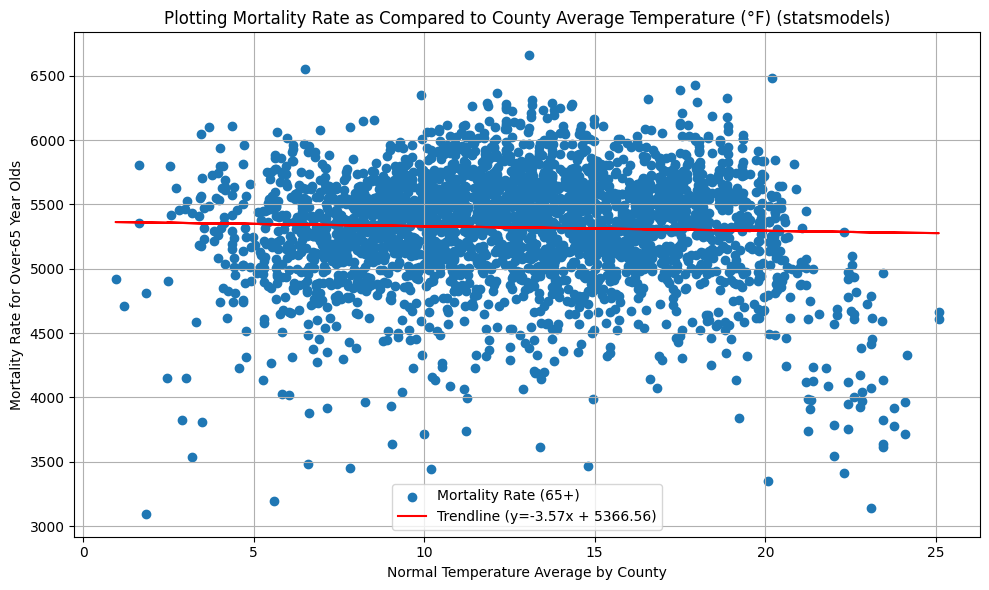

In [55]:
# 3(a)  exploring the relationship between county avg temp and over-65 mortality

# first, the suggested new columns in our data
popweight_tempdf['hotdays'] = popweight_tempdf['tday_70_80'] + popweight_tempdf['tday_80_90'] + popweight_tempdf['tday_gt90']
popweight_tempdf['hotterdays'] = popweight_tempdf['tday_80_90'] + popweight_tempdf['tday_gt90']

# next, grouping the counties and calculating mortality
avgtemp_over65df = popweight_tempdf.groupby('county_x')[['deaths','population','normal_1981_2010']].mean()
avgtemp_over65df['mort_rate'] = avgtemp_over65df['deaths'] / avgtemp_over65df['population']
avgtemp_over65df['mort_rate'] = avgtemp_over65df['mort_rate'] * 100000


# next, creating linear regression
model = smf.ols('mort_rate ~ normal_1981_2010', data=avgtemp_over65df)
results = model.fit()
avg_slope_sm = results.params['normal_1981_2010']
avg_intercept_sm = results.params['Intercept']

# printing the components of the linear regression
print(f'Slope (statsmodels): {avg_slope_sm}')
print(f'Intercept (statsmodels): {avg_intercept_sm}')

# last, plotting with the trendline
avg_trendline_sm = avg_intercept_sm + avg_slope_sm * avgtemp_over65df['normal_1981_2010']
plt.figure(figsize=(10, 6))
plt.scatter(avgtemp_over65df['normal_1981_2010'], avgtemp_over65df['mort_rate'], label='Mortality Rate (65+)')
plt.plot(avgtemp_over65df['normal_1981_2010'], avg_trendline_sm, color= 'red', linestyle='-', label=f'Trendline (y={avg_slope_sm:.2f}x + {avg_intercept_sm:.2f})')
plt.xlabel("Normal Temperature Average by County")
plt.ylabel("Mortality Rate for Over-65 Year Olds")
plt.title("Plotting Mortality Rate as Compared to County Average Temperature (°F) (statsmodels)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3(a) - interpreting our results

